In [1]:
from navground import sim,core
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import scipy.spatial.distance as dist
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr,spearmanr, shapiro, skew, iqr

import matplotlib.colors as colors
import matplotlib.cm as cmx
from navground.sim.ui.video import display_video, display_video_from_run

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# import created library for experiments.
import importlib.util
from pathlib import Path
ruta_archivo = Path("../../..") / "functions.py"
spec = importlib.util.spec_from_file_location("functions", ruta_archivo)
fu = importlib.util.module_from_spec(spec)
spec.loader.exec_module(fu)

2024-08-29 14:06:17.349086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 14:06:17.362565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 14:06:17.366805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 14:06:17.383094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 14:06:24.183720: W tensorflow/compiler/tf2

The collisions are given in an array with number of rows equal to the number of collisions in the whole simulation, i.e. if there are 50 collisions during a simulation, it will have 50 rows. The first column indicates the time instant in which the collision occurs and the other 2 columns specify the id of the robots that collide at that instant.

In [2]:
time_instances=1000
time_step=0.1
simulations = 100
length=10
width=1
behavior="ORCA"
#any missing space in the yaml or misspelling is an error.
yaml = f"""
steps: {time_instances}
time_step: {time_step}
runs: {simulations}
terminated_when_idle_or_stuck: false
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
record_efficacy: true
run_index: 0
scenario:
  type: Corridor
  agent_margin: 0.1
  length: {length}
  width: {width}
  target_margin: 0.5
  tolerance: 0.25
  groups:
    -
      type: thymio
      number: 40
      radius: 0.08
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: 0.166
      behavior:
        type: {behavior}
        optimal_speed: 0.12
        horizon: 5.0
        safety_margin:
          sampler: uniform
          from: 0.0
          to: 0.1
          once: true
      state_estimation:
        type: Bounded
        range: 5
"""

experimentORCA = sim.load_experiment(yaml)
experimentORCA.run(number_of_threads = 12) # with 0 threads 10 seconds 10 simulations, with 12 threads 1 second 10 simulations,
print(experimentORCA.duration)

0:00:02.959049


For visualize one of the simulations:

In [3]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
from navground.sim.ui.video import display_video, display_video_from_run
from navground.sim import Agent, Wall

i = 0
def linear_map(a, b, cmap):
    c = cmx.ScalarMappable(norm=colors.Normalize(vmin=a, vmax=b), cmap=cmap)  
    def f(v):
        r, g, b, _ = c.to_rgba(v)
        return f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}"
    return f


fill_map = linear_map(0.0, 1.0, cmap=cmx.RdYlGn)

def f(entity): #display collisions and deadlocks in the simulation in corridor scenarios
    if isinstance(entity, sim.Agent):
        return {'fill': 'red' if entity.has_been_in_collision_since(run.world.time - 0.5) 
            else 'blue' if entity.has_been_stuck_since(run.world.time - 0.5) 
            else 'lightgreen'}
    elif isinstance(entity, sim.Wall):
        return {'fill': 'red' if entity.has_been_in_collision_since(run.world.time - 0.5) else 'blue'}



run = experimentORCA.runs[i]
display_video_from_run(run, factor=3.0,
            bounds=(np.array([0,0]),np.array([length,width])), 
             decorate=f, width=600) # if the simulation is too long in timeit doesn't work, we must reduce number of time_instances or increase the factor variable to make a shorter video

Extract data from simulations, then we will calculate the persisten entropy time serie of each simulation

In [4]:
dfORCA = fu.extract_data(experimentORCA, behavior)
dfORCA

seeds  safety_margin  deadlocks  collisions  efficacy  safe  fluid  ok
0       0       0.054881          0          37  0.311494     0      1   0
1       1       0.041702          0          21  0.499371     0      1   0
2       2       0.043599          0          69  0.567931     0      1   0
3       3       0.055080          0         181  0.229170     0      1   0
4       4       0.096703          0           0  0.142730     1      1   1
..    ...            ...        ...         ...       ...   ...    ...  ..
95     95       0.022880          0          77  0.646466     0      1   0
96     96       0.021469          0           1  0.673227     0      1   0
97     97       0.083694          0         302  0.270242     0      1   0
98     98       0.073227          0           7  0.238101     0      1   0
99     99       0.067228          0          35  0.421170     0      1   0

[100 rows x 8 columns]

We see some statistal points from the parameters/info extracted, for example the 46% of the simulations are safe(no collisions)

In [5]:
dfORCA.describe()

seeds  safety_margin  deadlocks  collisions    efficacy  \
count  100.000000     100.000000      100.0  100.000000  100.000000   
mean    49.500000       0.047378        0.0  104.070000    0.474580   
std     29.011492       0.029102        0.0  126.226288    0.202908   
min      0.000000       0.001037        0.0    0.000000    0.115046   
25%     24.750000       0.022116        0.0   25.250000    0.309890   
50%     49.500000       0.044702        0.0   56.500000    0.456835   
75%     74.250000       0.072863        0.0  118.000000    0.611396   
max     99.000000       0.098901        0.0  667.000000    0.914903   

             safe  fluid          ok  
count  100.000000  100.0  100.000000  
mean     0.040000    1.0    0.040000  
std      0.196946    0.0    0.196946  
min      0.000000    1.0    0.000000  
25%      0.000000    1.0    0.000000  
50%      0.000000    1.0    0.000000  
75%      0.000000    1.0    0.000000  
max      1.000000    1.0    1.000000

Add the persistent entropy time series column. This take a bit of time, so if this has been calculated in another moment you only have to charge the dataframe, as is the same simulations.

In [6]:
if os.path.exists(f'Discriminant_{behavior}.pkl'):
    print("Charging existing dataframe with all the information")
    dfORCA = pd.read_pickle(f'Discriminant_{behavior}.pkl')
else:
    dfORCA['persistentEntropy'] = None
    for i in tqdm(range(simulations)):
        run = experimentORCA.runs[i]
        ps = run.poses
        maxd = [float(np.max(distance_matrix(X,X))) for X in ps[:,:,:2]]
        entropies=[]
        for j in range(ps.shape[0]):
            persistence = fu.ComputePersistenceDiagram(ps,j,0,"rips")
            persistenceL = fu.limitingDiagram(persistence,maxd[j])
            entropies.append(fu.EntropyCalculationFromBarcode(persistenceL))
        dfORCA.at[i, 'persistentEntropy'] = np.array(entropies)
    
    dfORCA.to_pickle(f'Discriminant_{behavior}.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:31:25<00:00, 54.85s/it]


## Relation between Collisions and Persistent entropy time series

-- Correlation between collisions y means
Pearson's correlation coefficient: -0.305074311098274
P-value: 0.002026546183633622
The correlation is statistically significant.
-- Correlation between collisions y medians
Pearson's correlation coefficient: -0.3064352733966032
P-value: 0.0019300968817514887
The correlation is statistically significant.
-- Correlation between collisions y stds
Pearson's correlation coefficient: 0.641067170220188
P-value: 6.747342097858888e-13
The correlation is statistically significant.
-- Correlation between collisions y skews
Pearson's correlation coefficient: 0.10937872971685264
P-value: 0.278679848842157
There is insufficient evidence to reject the null hypothesis of no correlation.
-- Correlation between collisions y iqrs
Pearson's correlation coefficient: 0.4306764902990259
P-value: 7.723901123479403e-06
The correlation is statistically significant.


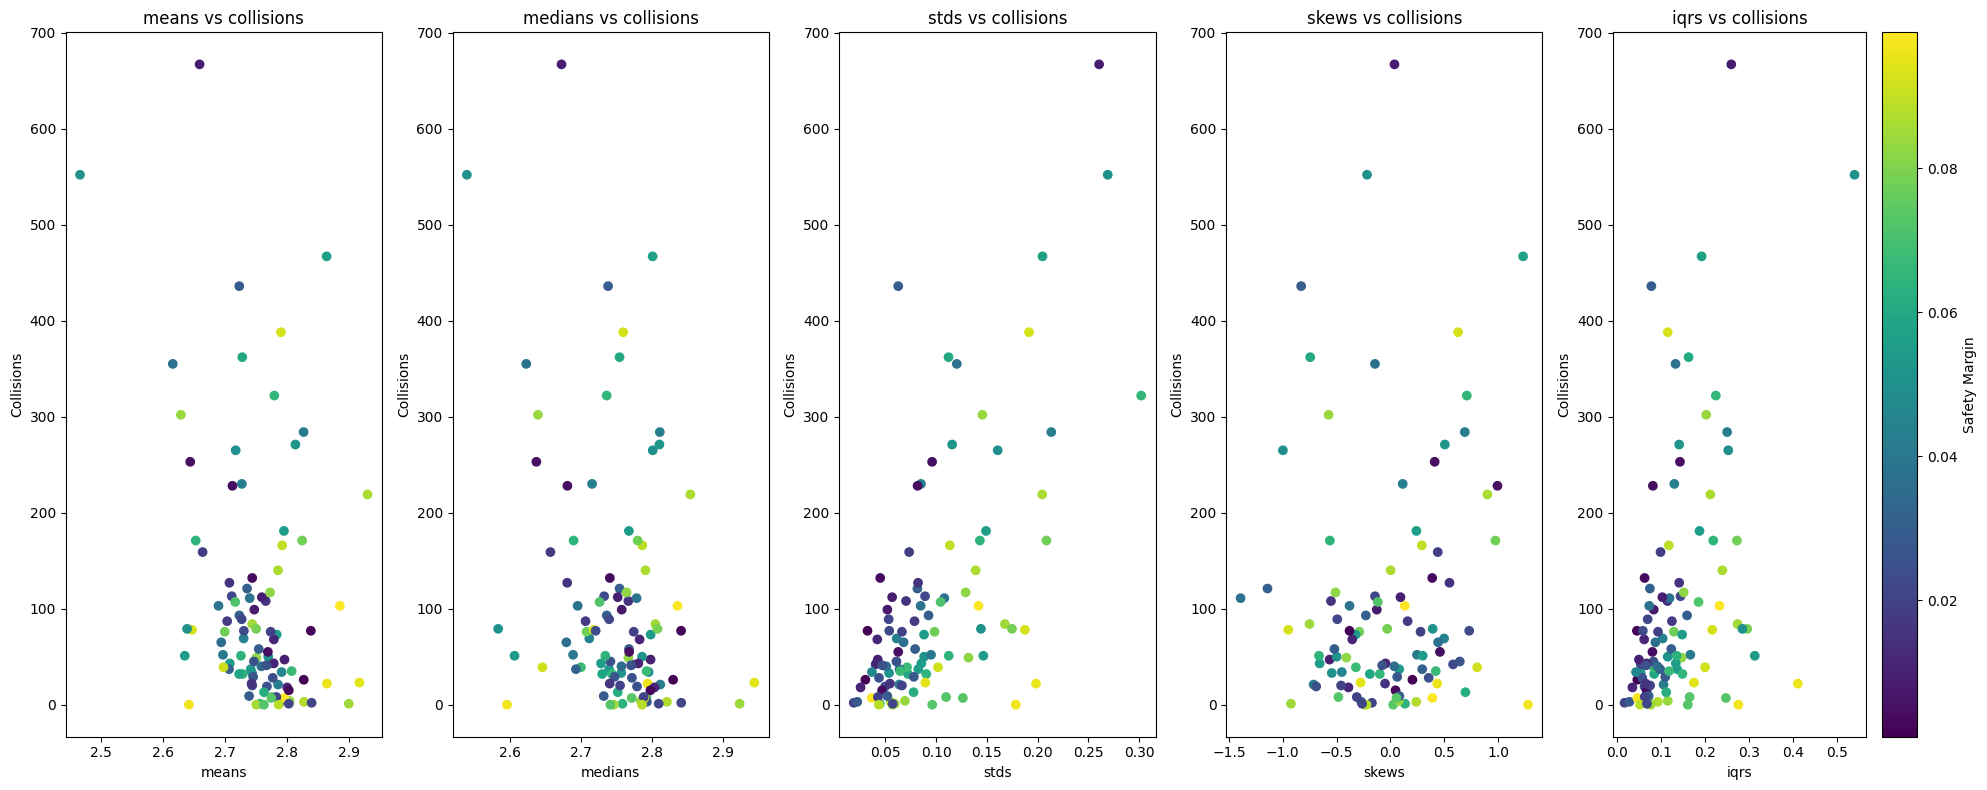

In [7]:
means=[]
medians=[]
stds=[]
skews=[]
iqrs=[]

for j in range(simulations):
    timeserie=dfORCA["persistentEntropy"].values[j]
    means.append(timeserie.mean())
    medians.append(np.median(timeserie))
    stds.append(timeserie.std())
    skews.append(skew(timeserie))
    iqrs.append(iqr(timeserie))

collisions= dfORCA["collisions"].values

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
axes = axes.flatten()

i=0
for x in [means,medians,stds,skews,iqrs]:
    feature2_name = [name for name in globals() if globals()[name] is x][0]
    print(f"-- Correlation between collisions y {feature2_name}")
    fu.show_correlation(collisions,x)
    plt.sca(axes[i])
    plt.scatter(x,collisions, c = dfORCA["safety_margin"].values)
    if i == 4:
        plt.colorbar(label='Safety Margin') 
    plt.title(f"{feature2_name} vs collisions")
    plt.xlabel(f"{feature2_name}")
    plt.ylabel('Collisions')
    i+=1

plt.tight_layout()
plt.savefig(f'Images/CorridorDiscriminantEntropy_Collisions_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

Visualize persistent entropy time series with collisions vs no collisions

10it [00:00, 888.28it/s]


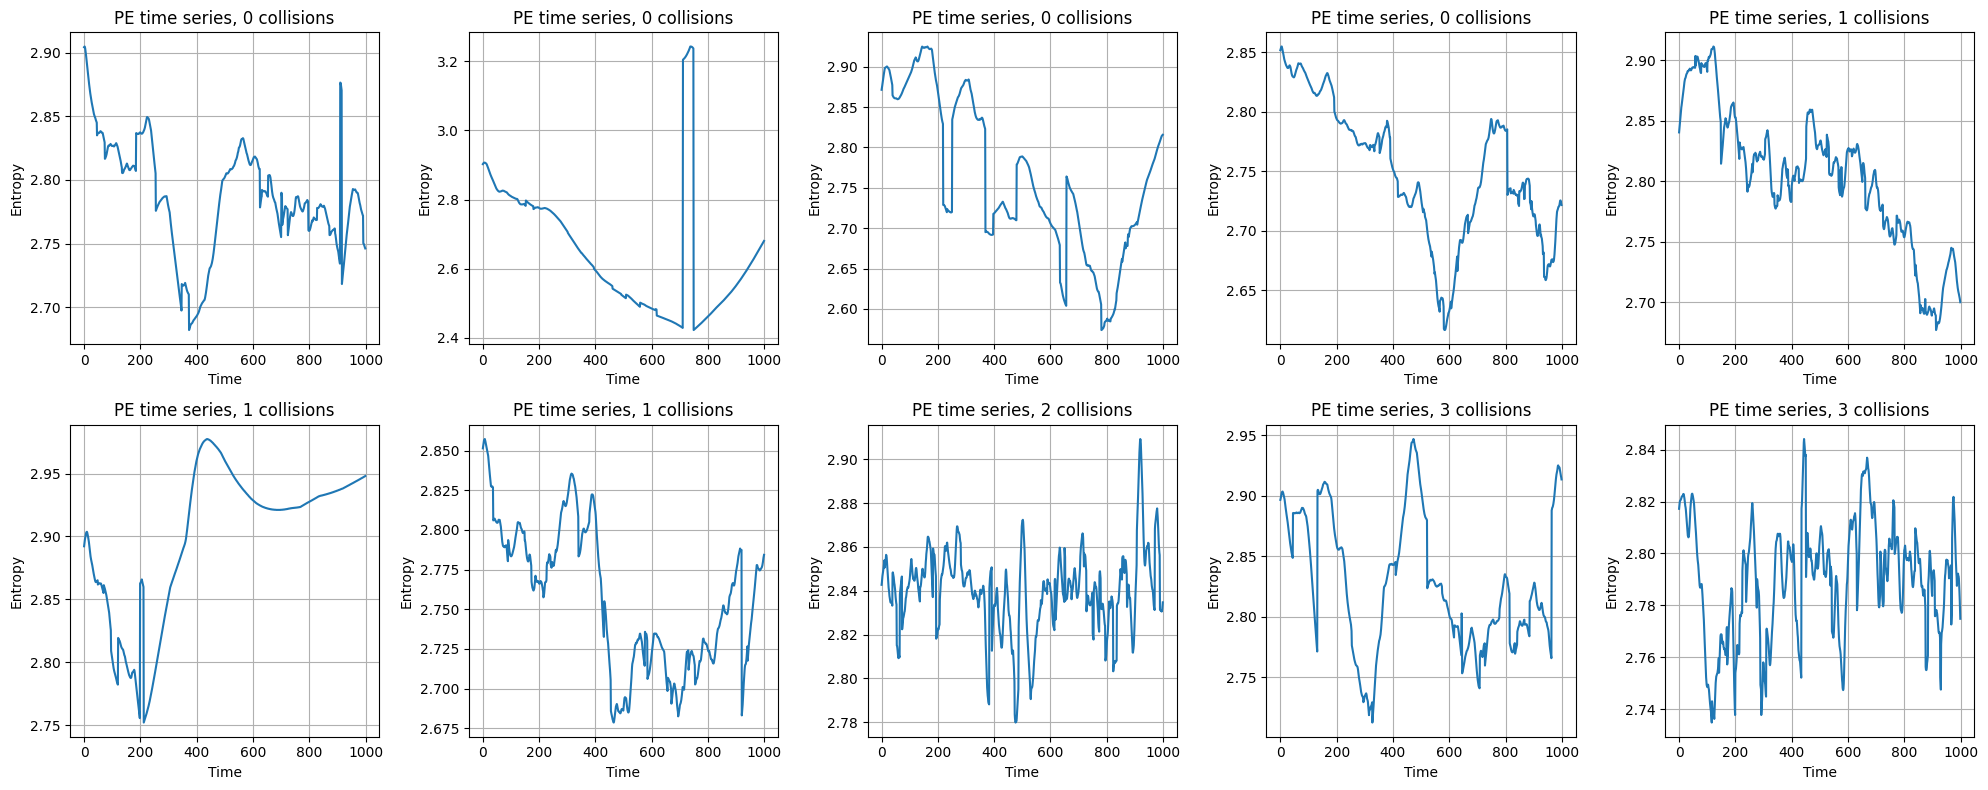

In [8]:
indexes_less_collisions=np.argsort(dfORCA["collisions"].values)[:10]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for cont,index in tqdm(enumerate(indexes_less_collisions)):
    timeserie=dfORCA["persistentEntropy"].values[index]
    # print(f"Mean : {timeserie.mean()}, Std : {timeserie.std()}, Media: {np.median(timeserie)}, Skewness: {skew(timeserie)}, IQR: {iqr(timeserie)}")
    plt.sca(axes[cont])
    fu.plotEntropyTimeSerie(timeserie)
    plt.title(f'PE time series, {dfORCA["collisions"].values[index]} collisions')
plt.tight_layout()
plt.savefig(f'Images/EntropyNoCollisionsTimeSeries_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

10it [00:00, 1344.93it/s]


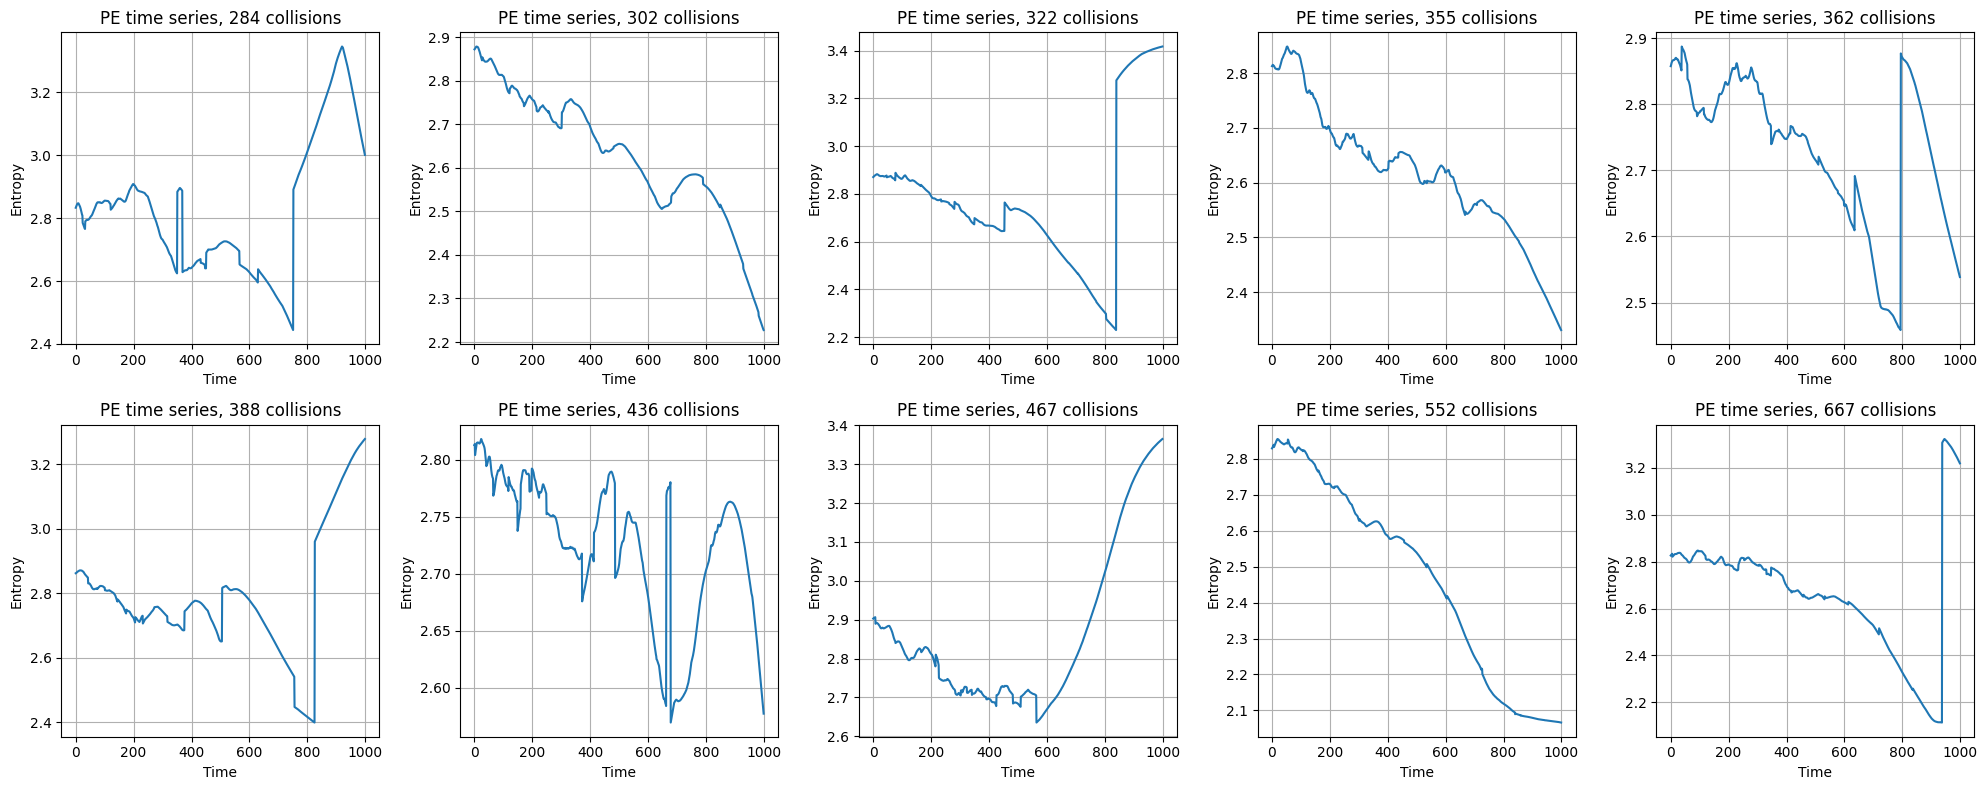

In [9]:
indexes_more_collisions=np.argsort(dfORCA["collisions"].values)[-10:]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for cont,index in tqdm(enumerate(indexes_more_collisions)):
    timeserie=dfORCA["persistentEntropy"].values[index]
    # print(f"Mean : {timeserie.mean()}, Std : {timeserie.std()}, Media: {np.median(timeserie)}, Skewness: {skew(timeserie)}, IQR: {iqr(timeserie)}")
    plt.sca(axes[cont])
    fu.plotEntropyTimeSerie(timeserie)
    plt.title(f'PE time series, {dfORCA["collisions"].values[index]} collisions')
plt.tight_layout()
plt.savefig(f'Images/EntropyCollisionsTimeSeries_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

## Relation between Efficacy and Persistent entropy time series

The efficacy is given for each robot in each time step, so for a simulation of 1000 time step and 40 robots is an array of shape (1000,40). Navground consider the mean of these array for know the efficacy of an specific simulation. The efficacy: the projection of the current velocity on the ideal velocity (ignoring obstacles) towards the target. A value of 1.0 denotes ideal efficacy, value of 0.0 that the agent is stuck.

-- Correlation between efficacy y means
Pearson's correlation coefficient: 0.06446116071908303
P-value: 0.5240138454061155
There is insufficient evidence to reject the null hypothesis of no correlation.
-- Correlation between efficacy y medians
Pearson's correlation coefficient: 0.1027459570552843
P-value: 0.3090407011451605
There is insufficient evidence to reject the null hypothesis of no correlation.
-- Correlation between efficacy y stds
Pearson's correlation coefficient: -0.6884972189142785
P-value: 2.4534312767595285e-15
The correlation is statistically significant.
-- Correlation between efficacy y skews
Pearson's correlation coefficient: -0.05344980902574546
P-value: 0.5973911328286631
There is insufficient evidence to reject the null hypothesis of no correlation.
-- Correlation between efficacy y iqrs
Pearson's correlation coefficient: -0.6587895444551939
P-value: 9.307780862832609e-14
The correlation is statistically significant.


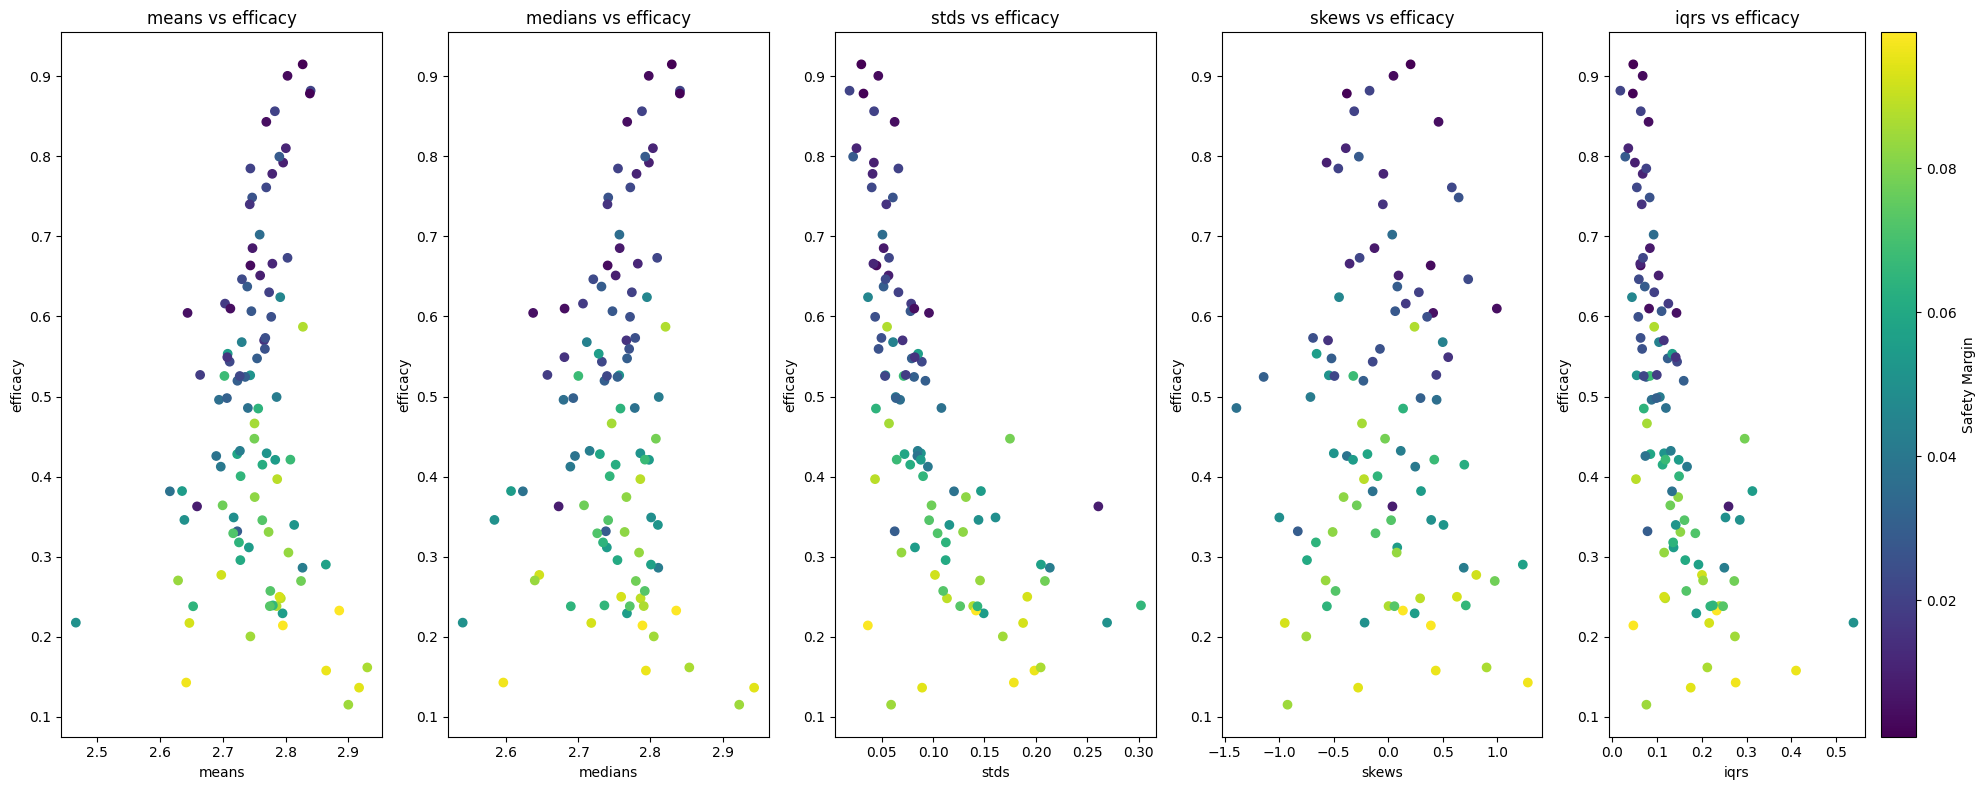

In [10]:
means=[]
medians=[]
stds=[]
skews=[]
iqrs=[]

for j in range(simulations):
    timeserie=dfORCA["persistentEntropy"].values[j]
    means.append(timeserie.mean())
    medians.append(np.median(timeserie))
    stds.append(timeserie.std())
    skews.append(skew(timeserie))
    iqrs.append(iqr(timeserie))

efficacy= dfORCA["efficacy"].values

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
axes = axes.flatten()

i=0
for x in [means,medians,stds,skews,iqrs]:
    feature2_name = [name for name in globals() if globals()[name] is x][0]
    print(f"-- Correlation between efficacy y {feature2_name}")
    fu.show_correlation(efficacy,x)
    plt.sca(axes[i])
    plt.scatter(x,efficacy, c = dfORCA["safety_margin"].values)
    if i == 4:
        plt.colorbar(label='Safety Margin') 
    plt.title(f"{feature2_name} vs efficacy")
    plt.xlabel(f"{feature2_name}")
    plt.ylabel('efficacy')
    i+=1

plt.tight_layout()
plt.savefig(f'Images/CorridorDiscriminantEntropy_efficacy_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

Visualize persistent entropy time series with less efficacy vs higher efficacy

10it [00:00, 1039.82it/s]


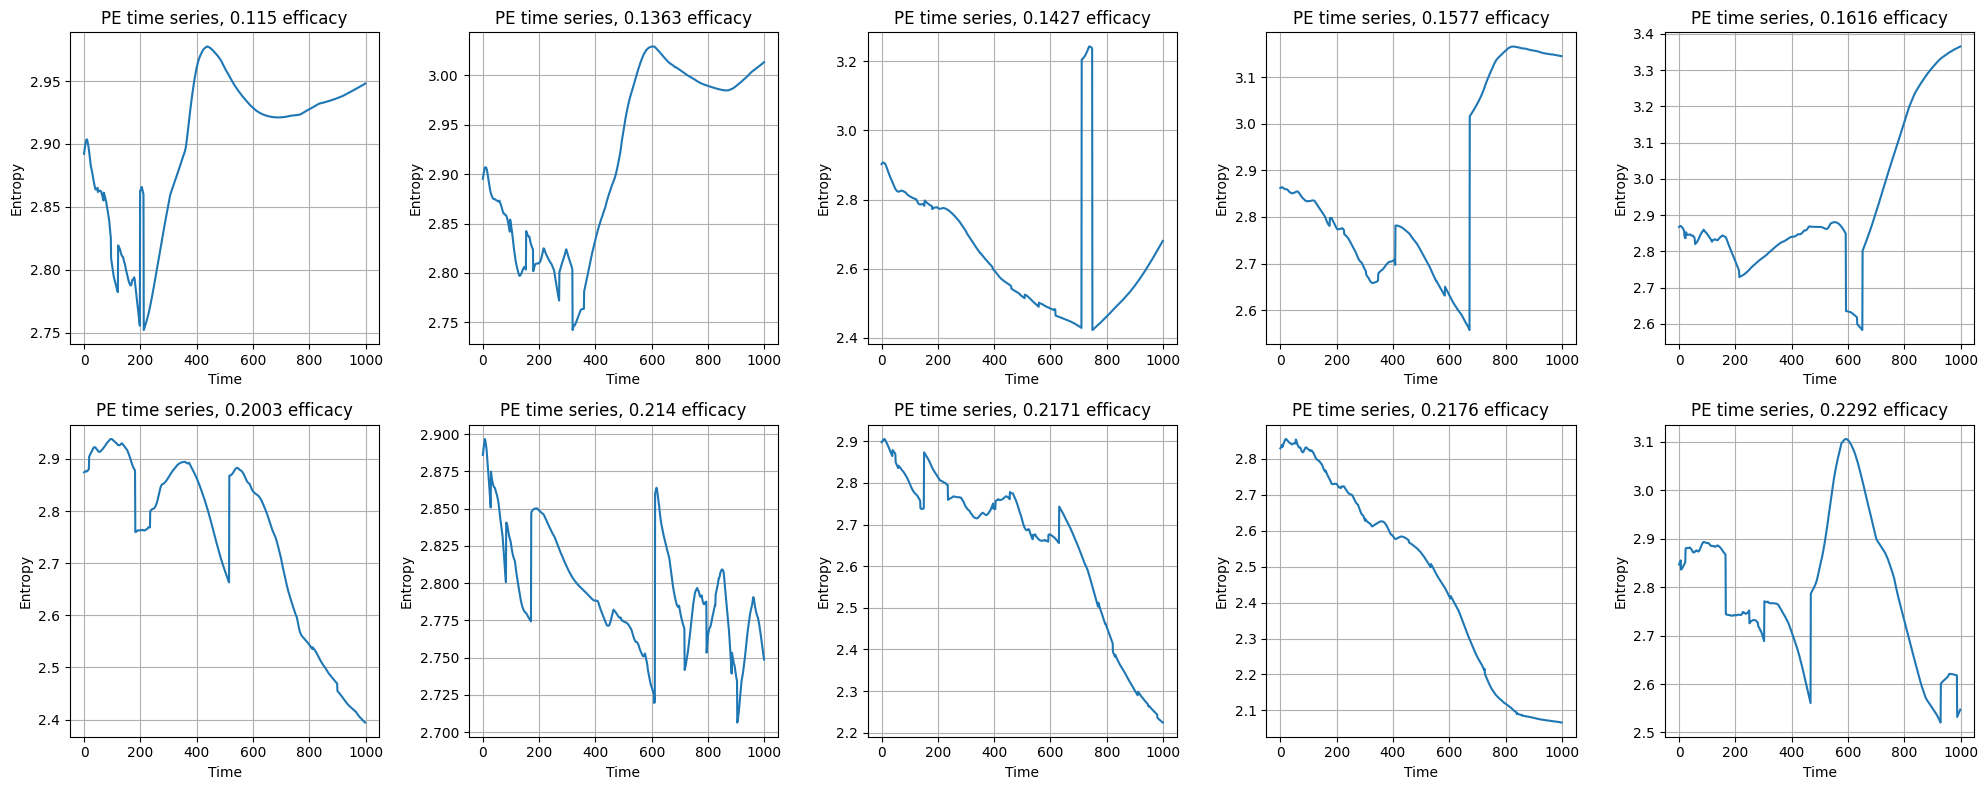

In [11]:
indexes_less_efficacys=np.argsort(dfORCA["efficacy"].values)[:10]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for cont,index in tqdm(enumerate(indexes_less_efficacys)):
    timeserie=dfORCA["persistentEntropy"].values[index]
    # print(f"Mean : {timeserie.mean()}, Std : {timeserie.std()}, Media: {np.median(timeserie)}, Skewness: {skew(timeserie)}, IQR: {iqr(timeserie)}")
    plt.sca(axes[cont])
    fu.plotEntropyTimeSerie(timeserie)
    efficacy = str(np.round(dfORCA["efficacy"].values[index],4))
    plt.title(f'PE time series, {efficacy} efficacy')
plt.tight_layout()
plt.savefig(f'Images/EntropyLessEfficacysTimeSeries_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

10it [00:00, 1517.53it/s]


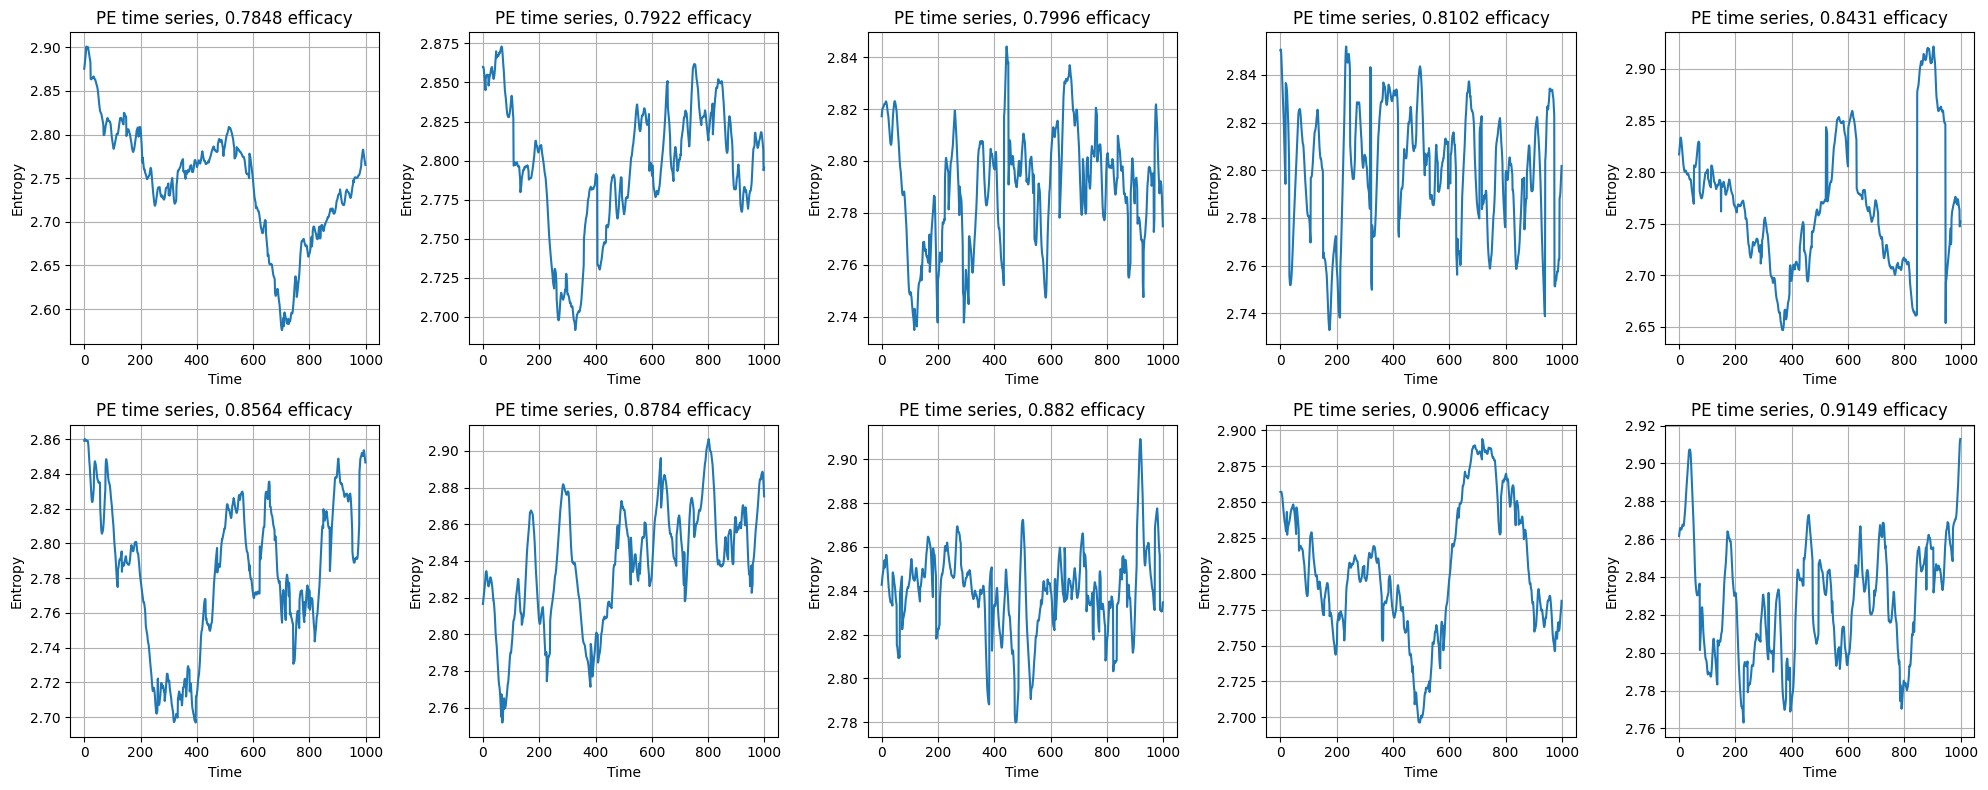

In [12]:
indexes_more_efficacys=np.argsort(dfORCA["efficacy"].values)[-10:]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for cont,index in tqdm(enumerate(indexes_more_efficacys)):
    timeserie=dfORCA["persistentEntropy"].values[index]
    # print(f"Mean : {timeserie.mean()}, Std : {timeserie.std()}, Media: {np.median(timeserie)}, Skewness: {skew(timeserie)}, IQR: {iqr(timeserie)}")
    plt.sca(axes[cont])
    fu.plotEntropyTimeSerie(timeserie)
    efficacy = str(np.round(dfORCA["efficacy"].values[index],4))
    plt.title(f'PE time series, {efficacy} efficacy')
plt.tight_layout()
plt.savefig(f'Images/EntropyMoreEfficacysTimeSeries_{behavior}.png', dpi=300, bbox_inches='tight')
plt.show()

We can see how the time series plot are completely different for simulations for high efficacy vs simulations for low efficacy

## See time series interval confidence for safe simulations vs no safe visualizations (don't take into account due to no significant results)

       Mean  Percentile_5  Percentile_95
0  2.855392      2.813455       2.893895
1  2.855281      2.813460       2.893930
2  2.854940      2.813495       2.893155
3  2.854567      2.813385       2.892395
4  2.853827      2.808385       2.891665


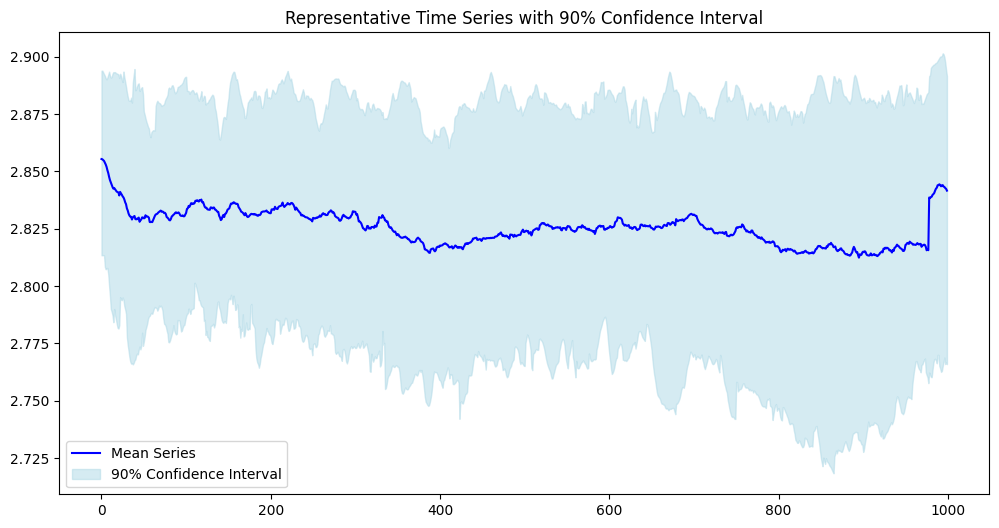

In [54]:
arrays=[]
for i in range(simulations):
    if (dfORCA["safe"][i] == 0) & (dfORCA["persistentEntropy"][i].shape[0] == 1000):
        arrays.append(dfORCA["persistentEntropy"][i])
arrays_stacked = np.stack(arrays, axis=1)  # Une los arrays a lo largo de un nuevo eje (eje 1)

df = pd.DataFrame(arrays_stacked)

# Calcula la serie temporal representativa (promedio)
mean_series = df.mean(axis=1)

# Calcula el intervalo de confianza del 90%
percentile_5 = df.quantile(0.05, axis=1)
percentile_95 = df.quantile(0.95, axis=1)

# Crear un DataFrame con los resultados
representative_series = pd.DataFrame({
    "Mean": mean_series,
    "Percentile_5": percentile_5,
    "Percentile_95": percentile_95
})

# Gráfica opcional
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(representative_series.index, representative_series["Mean"], label="Mean Series", color="blue")
plt.fill_between(representative_series.index, representative_series["Percentile_5"], representative_series["Percentile_95"], color="lightblue", alpha=0.5, label="90% Confidence Interval")
plt.legend()
plt.title("Representative Time Series with 90% Confidence Interval")
plt.show()
                      

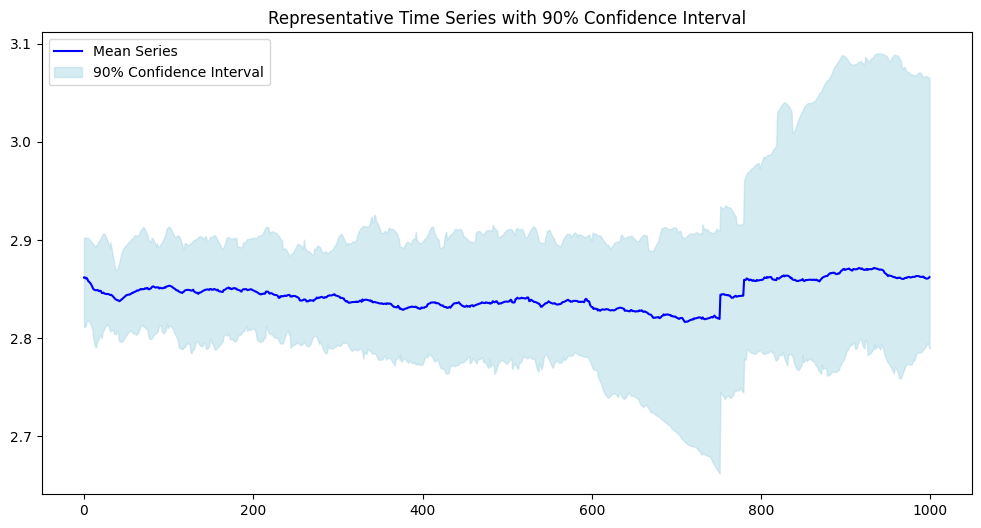

In [56]:
arrays=[]
for i in range(simulations):
    if (dfORCA["safe"][i] == 1) & (dfORCA["persistentEntropy"][i].shape[0] == 1000):
        arrays.append(dfORCA["persistentEntropy"][i])
arrays_stacked = np.stack(arrays, axis=1)  # Une los arrays a lo largo de un nuevo eje (eje 1)

df = pd.DataFrame(arrays_stacked)

# Calcula la serie temporal representativa (promedio)
mean_series = df.mean(axis=1)

# Calcula el intervalo de confianza del 90%
percentile_5 = df.quantile(0.05, axis=1)
percentile_95 = df.quantile(0.95, axis=1)

# Crear un DataFrame con los resultados
representative_series = pd.DataFrame({
    "Mean": mean_series,
    "Percentile_5": percentile_5,
    "Percentile_95": percentile_95
})

# Gráfica opcional
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(representative_series.index, representative_series["Mean"], label="Mean Series", color="blue")
plt.fill_between(representative_series.index, representative_series["Percentile_5"], representative_series["Percentile_95"], color="lightblue", alpha=0.5, label="90% Confidence Interval")
plt.legend()
plt.title("Representative Time Series with 90% Confidence Interval")
plt.show()

## Neural network example (don't take into account)

In [15]:
X = []
for i in dfORCA["persistentEntropy"]:
    X.append(i)
X = np.array(X)
y = np.array(dfORCA['safe'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Input((X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3542 - loss: 1.3395 - val_accuracy: 0.8750 - val_loss: 0.3785
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4896 - loss: 0.9074 - val_accuracy: 0.1250 - val_loss: 1.2584
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3854 - loss: 0.8903 - val_accuracy: 0.8750 - val_loss: 0.4313
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6042 - loss: 0.7519 - val_accuracy: 0.8750 - val_loss: 0.3921
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6250 - loss: 0.7183 - val_accuracy: 0.1250 - val_loss: 0.7158
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3750 - loss: 0.7139 - val_accuracy: 0.1250 - val_loss: 0.8167
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4167 - loss: 0.7284 - val_accuracy: 0.8750 - val_loss: 0.4582
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6146 - loss: 0.6991 - val_accuracy: 0.8750 - v

In [16]:
X.shape

(100, 1000)

In [13]:
y_test

array([0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1])

In [14]:
model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.36999366],
       [0.37269762],
       [0.372987  ],
       [0.36518964],
       [0.3662911 ],
       [0.37008545],
       [0.37276635],
       [0.36916164],
       [0.36727533],
       [0.37098733],
       [0.3723745 ],
       [0.3694191 ],
       [0.37092936],
       [0.37126455],
       [0.37131277],
       [0.3675442 ],
       [0.36862144],
       [0.37018397],
       [0.3700319 ],
       [0.36991483]], dtype=float32)